---
---
# Learning a generative network with GMM-OT loss

In this notebook, we show how a procedure to learn a generative model $\mu_\theta$ by solving the problem:
\begin{equation}
    \min_{\theta\in\Theta} MW_2^2\left(\mathcal{G}_K\left[\mu_\theta {}_\#\mathcal{L}\right]),\mathcal{G}_K(\nu)\right)
\end{equation}
where:
- for all distribution $p$, $\mathcal{G}_K[p]$ denotes the best GMM approximation with K components of $p$,
- $\mathcal{L}$ is the "latent" distribution ($\mathcal{L}=\mathcal{N}(\mathbf{0}_n, \text{Id}_n)$ at the beginning),
- $\nu$ is the "real" distribution that we want to model. 

---
---

/!\ We use the package ```scienceplots```that requires a LaTeX distribution. In case you don't have it, please comment the following lines

```python
import scienceplots
plt.style.use("science")
```

/!\ The code to draw the GMM was copied from a notebook of Rémi Flamary


# 1. Standard imports and utils

In [1]:
import ot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import scienceplots

import torch
import torch.nn as nn
import torch.optim as optim

import time

# from ot.utils import proj_SDP, proj_simplex
seed = 10
plt.style.use("science")
torch.random.manual_seed(seed)

In [2]:
def gaussian_pdf(
    x: torch.tensor, mu: torch.tensor, sigma: torch.tensor, eps=1e-6
):
    """Compute the Gaussian probability density function."""
    d = x.shape[1]
    det_sigma = torch.det(sigma + eps * torch.eye(d))
    norm_const = 1.0 / ((2 * torch.pi) ** (d / 2) * torch.sqrt(det_sigma + eps))
    diff = x - mu
    exponent = -0.5 * torch.sum(diff @ torch.linalg.inv(sigma) * diff, dim=1)
    return norm_const * torch.exp(exponent)


def gaussian_pdf_log(
    X: torch.tensor, mu: torch.tensor, sigma: torch.tensor, eps=0
):
    """Compute the log of Gaussian density (with eps in case
    sigma has degenerate directions)"""
    d = X.shape[1]
    diff = X - mu
    inv_sigma = torch.inverse(sigma + eps * torch.eye(d))
    log_det_sigma = torch.logdet(sigma + eps * torch.eye(d))
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, dim=1)
    log_coef = -0.5 * (d * torch.log(torch.tensor(2 * np.pi)) + log_det_sigma)
    return log_coef + exponent


In [3]:
def sample_gmm(
    n_samples: int, mu: torch.tensor, sigma: torch.tensor, pi: torch.tensor
):
    """Generate samples from"""
    k, d = mu.shape
    labels = torch.multinomial(
        pi, n_samples, replacement=True
    )  # Sample component indices

    samples = torch.zeros((n_samples, d))
    for i in range(k):
        num_samples = (labels == i).sum().item()
        if n_samples > 0:
            samples[labels == i] = torch.distributions.MultivariateNormal(
                mu[i], sigma[i]
            ).sample((num_samples,))

    return samples, labels


In [4]:
def draw_cov(mu, C, color=None, label=None, nstd=1, alpha=0.5, fill=True):
    def eigsorted(cov):
        if torch.is_tensor(cov):
            cov = cov.detach().numpy()
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1].copy()
        return vals[order], vecs[:, order]

    vals, vecs = eigsorted(C)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(
        xy=(mu[0], mu[1]),
        width=w,
        height=h,
        alpha=alpha,
        angle=theta,
        facecolor=color,
        edgecolor=color,
        label=label,
        fill=fill,
    )
    plt.gca().add_artist(ell)


def draw_gmm(ms, Cs, ws, color=None, nstd=1.96, alpha=1, fill=True):
    for k in range(ms.shape[0]):
        draw_cov(ms[k], Cs[k], color, None, nstd, alpha, fill=fill)


# 2. Initial Params

In [5]:
toy_example = "circle"  # try "2 modes" or "3 modes"
match toy_example:
    case "circle":
        d = 2
        r1 = 0.85
        r2 = 0.2
        sq2inv = 2 ** (-0.5)
        cov_circle = [
            [[1, 0], [0, r2]],
            [[1, -r1], [-r1, 1]],
            [[r2, 0], [0, 1]],
            [[1, +r1], [+r1, 1]],
            [[1, 0], [0, r2]],
            [[1, -r1], [-r1, 1]],
            [[r2, 0], [0, 1]],
            [[1, +r1], [+r1, 1]],
        ]
        mean_circle = [
            [0.0, 1.0],
            [sq2inv, sq2inv],
            [1.0, 0.0],
            [(sq2inv), -(sq2inv)],
            [0.0, -1.0],
            [-(sq2inv), -(sq2inv)],
            [-1.0, 0.0],
            [-(sq2inv), (sq2inv)],
        ]
        kt = len(mean_circle)
        m_t = 8 * torch.tensor(mean_circle)
        C_t = 0.5 * torch.tensor(cov_circle)
        w_t = torch.tensor(ot.unif(kt))

    case "2 modes":
        d = 2
        C_t = torch.tensor(
            [
                [[1, 0.75], [0.75, 1]],
                [[1, -0.75], [-0.75, 1]],
            ]
        )
        m_t = torch.tensor([[5.0, -5.0], [-5.0, 5.0]])
        kt = len(C_t)
        w_t = torch.tensor(ot.unif(kt))

    case "3 modes":
        d = 2
        C_t = torch.tensor(
            [
                [[1, 0.75], [0.75, 1]],
                [[1, -0.75], [-0.75, 1]],
                [[2, -0.75], [-0.75, 2]],
            ]
        )
        m_t = torch.tensor([[5.0, -5.0], [-5.0, 5.0], [5.0, 5.0]])
        kt = len(C_t)
        w_t = torch.tensor(ot.unif(kt))


# 3. Stable EM Algorithm

## Samples

In [6]:
n_samples = 10_000
X, labels = sample_gmm(n_samples, m_t, C_t, w_t)


## "Logtau" function

In [7]:
def compute_log_tau(X, mu, sigma, pi, eps=0):
    """Compute the log-tau quantity as defined in the report."""
    k = len(mu)
    n_samples = X.shape[0]

    log_tau_tilde = torch.zeros((n_samples, k), dtype=X.dtype)
    for i in range(k):
        log_tau_tilde[:, i] = torch.log(pi[i]) + gaussian_pdf_log(
            X, mu[i], sigma[i], eps=eps
        )

    log_tau = log_tau_tilde - torch.logsumexp(
        log_tau_tilde, dim=1, keepdim=True
    )
    return log_tau


## EM Algorithm

In [8]:
k = kt
iter_GMM = 100


# Initialisation
mu = X[torch.randperm(n_samples)[:k]]
sigma = 3 * torch.stack([torch.eye(d, dtype=X.dtype) for _ in range(k)]) + 0.5
pi = torch.full((k,), 1 / k, dtype=X.dtype)
log_likelihood_list = []

for _ in range(iter_GMM):
    # E-step
    log_tau = compute_log_tau(X, mu, sigma, pi)

    # M-step
    tau = torch.exp(compute_log_tau(X, mu, sigma, pi))
    k = len(mu)
    n_samples = X.shape[0]

    Nk = tau.sum(axis=0)
    pi = Nk / n_samples
    mu = (tau.T @ X) / Nk[:, None]

    sigma = torch.stack(
        [
            (tau[:, i, None] * (X - mu[i])).T @ (X - mu[i]) / Nk[i]
            for i in range(k)
        ]
    )

    # Log-likelihood
    log_likelihood = torch.sum(torch.logsumexp(log_tau, dim=1))
    log_likelihood_list.append(log_likelihood.item())

    if torch.isnan(log_likelihood):
        break

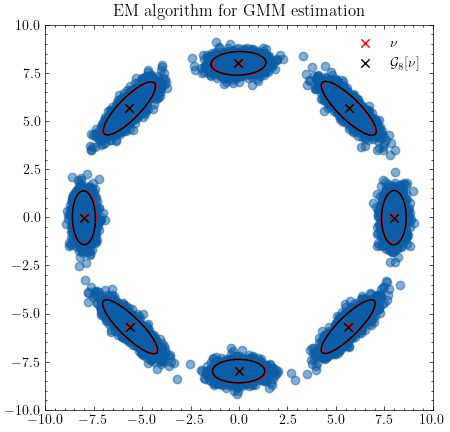

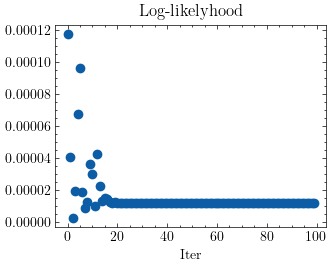

In [9]:
plt.figure(1, (5, 5))
plt.clf()
plt.title("EM algorithm for GMM estimation")

plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
draw_gmm(m_t, C_t, w_t, color="red", alpha=1, fill=False)
plt.scatter(
    m_t[:, 0], m_t[:, 1], color="red", marker="x", alpha=1, label=r"$\nu$"
)
draw_gmm(mu, sigma, pi, color="black", fill=False, alpha=1)
plt.scatter(
    mu[:, 0],
    mu[:, 1],
    color="black",
    marker="x",
    alpha=1,
    label=rf"$\mathcal{{G}}_{{{k}}}[\nu]$",
)

plt.axis([-10, 10, -10, 10])
plt.legend()
plt.show()

plt.figure()
plt.scatter(np.arange(len(log_likelihood_list)), log_likelihood_list)
plt.title("Log-likelyhood")
plt.xlabel("Iter")
plt.show()


# Generator

In [10]:
# # for small dataset
# class Generator(torch.nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.fc1 = nn.Linear(2, 50)
#         self.fc2 = nn.Linear(50, 70)
#         self.fc3 = nn.Linear(70, 50)
#         self.fc4 = nn.Linear(50, 2)
#         self.relu = torch.nn.ReLU()  # instead of Heaviside step fn

#     def forward(self, x):
#         output = self.fc1(x)
#         output = self.relu(output)  # instead of Heaviside step fn
#         output = self.fc2(output)
#         output = self.relu(output)
#         output = self.fc3(output)
#         output = self.relu(output)
#         output = self.fc4(output)
#         return output


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 700)
        self.fc3 = nn.Linear(700, 200)
        self.fc4 = nn.Linear(200, 2)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)
        output = self.relu(output)
        output = self.fc4(output)
        return output


f_theta = Generator()

print(f"Total parameters: {sum(p.numel() for p in f_theta.parameters())}")


Total parameters: 281902


In [11]:
torch.randint(0, 100, (10,))

tensor([65, 21, 90, 50, 76, 85, 53, 14, 86, 92])

# Training

## Plot utils

In [12]:
def plot_training(epoch, x_theta, mu, sigma, pi, k):
    plt.figure(figsize=(5, 5))
    plt.title(rf"\sffamily Epoch {epoch}")
    plt.scatter(
        x_theta[:, 0].detach().numpy(),
        x_theta[:, 1].detach().numpy(),
        alpha=0.1,
        label=r"$z$",
        color="blue",
    )
    draw_gmm(
        mu.detach().numpy(),
        sigma.detach().numpy(),
        pi.detach().numpy(),
        color="black",
        fill=False,
        alpha=1,
    )
    draw_gmm(
        m_t.detach().numpy(),
        C_t.detach().numpy(),
        w_t.detach().numpy(),
        color="red",
        fill=False,
        alpha=1,
    )
    plt.scatter(
        mu[:, 0].detach().numpy(),
        mu[:, 1].detach().numpy(),
        label=rf"$\mathcal{{G}}_{{{k}}}[\mu_\theta(z)]$",
        marker="x",
        color="black",
    )
    plt.scatter(
        m_t[:, 0].detach().numpy(),
        m_t[:, 1].detach().numpy(),
        label=rf"$\mathcal{{G}}_{{{k}}}[\nu]$",
        marker="x",
        color="red",
    )

    plt.axis([-10, 10, -10, 10])
    plt.legend()
    plt.gca().set_aspect("equal")
    plt.xticks([])
    plt.yticks([])
    plt.show()


## Training code

Epoch 0/1000 | Loss: 64.7505 | Diff MLE: 9.54e-06 | Time 3.89e+00s


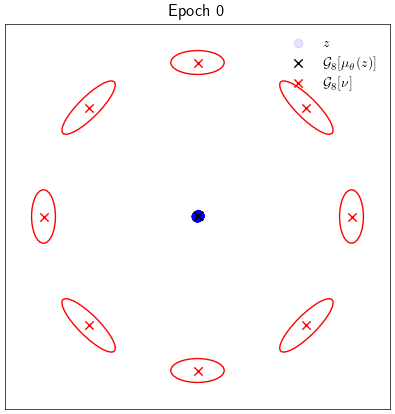

Epoch 1/1000 | Loss: 63.9832 | Diff MLE: 7.24e-06 | Time 3.91e+00s
Epoch 2/1000 | Loss: 63.2916 | Diff MLE: -4.32e-06 | Time 4.12e+00s
Epoch 3/1000 | Loss: 62.6168 | Diff MLE: 2.83e-06 | Time 4.02e+00s
Epoch 4/1000 | Loss: 61.8239 | Diff MLE: 4.81e-06 | Time 4.01e+00s
Epoch 5/1000 | Loss: 60.9115 | Diff MLE: 1.68e-06 | Time 4.41e+00s
Epoch 6/1000 | Loss: 60.0936 | Diff MLE: 6.14e-07 | Time 3.97e+00s
Epoch 7/1000 | Loss: 59.1586 | Diff MLE: -4.03e-06 | Time 3.82e+00s
Epoch 8/1000 | Loss: 58.3932 | Diff MLE: 4.20e-06 | Time 3.80e+00s
Epoch 9/1000 | Loss: 57.3513 | Diff MLE: -5.14e-07 | Time 4.87e+00s
Epoch 10/1000 | Loss: 56.1996 | Diff MLE: -7.04e-06 | Time 8.86e-01s
Epoch 11/1000 | Loss: 55.2168 | Diff MLE: -1.31e-07 | Time 7.70e-01s
Epoch 12/1000 | Loss: 54.0318 | Diff MLE: 1.47e-07 | Time 6.18e-01s
Epoch 13/1000 | Loss: 52.9424 | Diff MLE: -2.03e-07 | Time 7.86e-01s
Epoch 14/1000 | Loss: 51.4840 | Diff MLE: 4.24e-06 | Time 1.05e+00s
Epoch 15/1000 | Loss: 50.2171 | Diff MLE: -4.25e-06

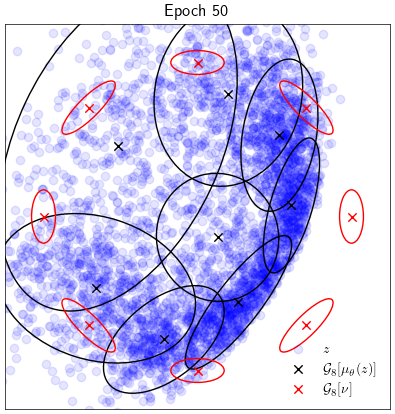

Epoch 51/1000 | Loss: 18.0197 | Diff MLE: -3.05e-06 | Time 7.77e-01s
Epoch 52/1000 | Loss: 17.5958 | Diff MLE: 2.08e-05 | Time 7.55e-01s
Epoch 53/1000 | Loss: 17.6195 | Diff MLE: 9.57e-06 | Time 7.97e-01s
Epoch 54/1000 | Loss: 16.6686 | Diff MLE: 1.96e-06 | Time 7.32e-01s
Epoch 55/1000 | Loss: 15.7997 | Diff MLE: -4.68e-06 | Time 7.34e-01s
Epoch 56/1000 | Loss: 16.4037 | Diff MLE: -2.66e-06 | Time 7.73e-01s
Epoch 57/1000 | Loss: 15.7501 | Diff MLE: 1.96e-05 | Time 9.87e-01s
Epoch 58/1000 | Loss: 16.3631 | Diff MLE: -4.17e-06 | Time 1.01e+00s
Epoch 59/1000 | Loss: 14.9671 | Diff MLE: 9.21e-06 | Time 1.03e+00s
Epoch 60/1000 | Loss: 15.2727 | Diff MLE: -1.96e-05 | Time 1.08e+00s
Epoch 61/1000 | Loss: 14.3557 | Diff MLE: -9.37e-06 | Time 1.05e+00s
Epoch 62/1000 | Loss: 14.5627 | Diff MLE: -3.16e-06 | Time 1.16e+00s
Epoch 63/1000 | Loss: 14.2002 | Diff MLE: 3.38e-06 | Time 1.05e+00s
Epoch 64/1000 | Loss: 14.1054 | Diff MLE: 1.02e-05 | Time 8.59e-01s
Epoch 65/1000 | Loss: 14.0733 | Diff MLE:

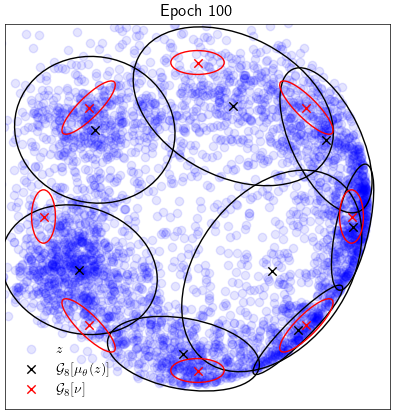

Epoch 101/1000 | Loss: 10.4782 | Diff MLE: 1.30e-05 | Time 6.87e-01s
Epoch 102/1000 | Loss: 10.4899 | Diff MLE: -4.93e-06 | Time 7.62e-01s
Epoch 103/1000 | Loss: 10.0791 | Diff MLE: -2.35e-06 | Time 7.47e-01s
Epoch 104/1000 | Loss: 10.4174 | Diff MLE: -1.64e-05 | Time 6.94e-01s
Epoch 105/1000 | Loss: 10.8926 | Diff MLE: 2.68e-05 | Time 7.03e-01s
Epoch 106/1000 | Loss: 11.8077 | Diff MLE: 6.67e-07 | Time 6.93e-01s
Epoch 107/1000 | Loss: 11.5668 | Diff MLE: -1.64e-05 | Time 6.83e-01s
Epoch 108/1000 | Loss: 11.6859 | Diff MLE: -7.69e-06 | Time 6.95e-01s
Epoch 109/1000 | Loss: 10.9802 | Diff MLE: -9.89e-06 | Time 7.41e-01s
Epoch 110/1000 | Loss: 10.4967 | Diff MLE: 2.51e-05 | Time 7.07e-01s
Epoch 111/1000 | Loss: 10.2112 | Diff MLE: -3.38e-06 | Time 6.70e-01s
Epoch 112/1000 | Loss: 10.8212 | Diff MLE: -1.75e-05 | Time 6.94e-01s
Epoch 113/1000 | Loss: 11.2457 | Diff MLE: 2.94e-05 | Time 7.06e-01s
Epoch 114/1000 | Loss: 11.0396 | Diff MLE: -1.25e-05 | Time 7.46e-01s
Epoch 115/1000 | Loss: 12

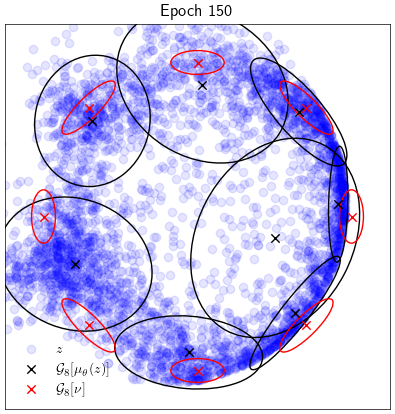

Epoch 151/1000 | Loss: 8.7545 | Diff MLE: -2.69e-06 | Time 6.85e-01s
Epoch 152/1000 | Loss: 7.5888 | Diff MLE: 4.76e-06 | Time 7.46e-01s
Epoch 153/1000 | Loss: 8.3717 | Diff MLE: 9.57e-06 | Time 6.77e-01s
Epoch 154/1000 | Loss: 8.1761 | Diff MLE: -4.28e-06 | Time 7.04e-01s
Epoch 155/1000 | Loss: 8.1844 | Diff MLE: 1.55e-06 | Time 7.05e-01s
Epoch 156/1000 | Loss: 8.0562 | Diff MLE: 2.25e-05 | Time 6.79e-01s
Epoch 157/1000 | Loss: 7.9019 | Diff MLE: -5.38e-06 | Time 7.08e-01s
Epoch 158/1000 | Loss: 7.8381 | Diff MLE: 2.28e-05 | Time 6.55e-01s
Epoch 159/1000 | Loss: 7.9025 | Diff MLE: -3.14e-06 | Time 6.75e-01s
Epoch 160/1000 | Loss: 7.6229 | Diff MLE: -9.65e-06 | Time 7.43e-01s
Epoch 161/1000 | Loss: 8.5661 | Diff MLE: 3.26e-06 | Time 7.59e-01s
Epoch 162/1000 | Loss: 7.7878 | Diff MLE: -2.77e-05 | Time 7.34e-01s
Epoch 163/1000 | Loss: 7.4072 | Diff MLE: 1.29e-05 | Time 7.53e-01s
Epoch 164/1000 | Loss: 7.5594 | Diff MLE: 7.32e-06 | Time 7.30e-01s
Epoch 165/1000 | Loss: 7.7833 | Diff MLE: 

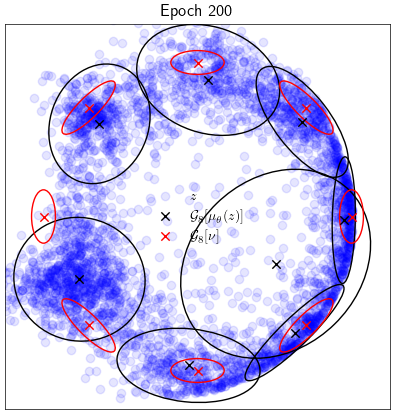

Epoch 201/1000 | Loss: 7.0991 | Diff MLE: 1.79e-05 | Time 8.61e-01s
Epoch 202/1000 | Loss: 7.1479 | Diff MLE: 2.92e-06 | Time 9.68e-01s
Epoch 203/1000 | Loss: 7.2716 | Diff MLE: 6.81e-06 | Time 8.03e-01s
Epoch 204/1000 | Loss: 7.5090 | Diff MLE: -2.00e-05 | Time 1.10e+00s
Epoch 205/1000 | Loss: 7.3676 | Diff MLE: -1.35e-05 | Time 9.40e-01s
Epoch 206/1000 | Loss: 6.7464 | Diff MLE: 2.20e-06 | Time 8.50e-01s
Epoch 207/1000 | Loss: 6.9070 | Diff MLE: 1.26e-05 | Time 7.20e-01s
Epoch 208/1000 | Loss: 7.4101 | Diff MLE: -6.74e-06 | Time 9.00e-01s
Epoch 209/1000 | Loss: 7.9587 | Diff MLE: 1.44e-05 | Time 8.28e-01s
Epoch 210/1000 | Loss: 7.0079 | Diff MLE: 2.23e-06 | Time 1.00e+00s
Epoch 211/1000 | Loss: 6.6934 | Diff MLE: 1.99e-05 | Time 8.02e-01s
Epoch 212/1000 | Loss: 6.6997 | Diff MLE: -5.38e-06 | Time 8.14e-01s
Epoch 213/1000 | Loss: 7.0848 | Diff MLE: -7.23e-06 | Time 8.03e-01s
Epoch 214/1000 | Loss: 7.5986 | Diff MLE: -1.13e-05 | Time 8.81e-01s
Epoch 215/1000 | Loss: 8.1638 | Diff MLE: 

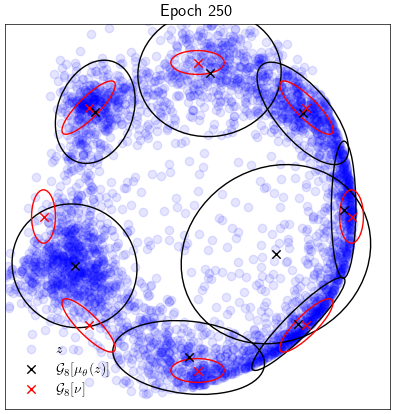

Epoch 251/1000 | Loss: 6.2888 | Diff MLE: -1.42e-05 | Time 1.21e+00s
Epoch 252/1000 | Loss: 6.8614 | Diff MLE: -1.80e-05 | Time 9.02e-01s
Epoch 253/1000 | Loss: 6.5700 | Diff MLE: -7.31e-06 | Time 1.08e+00s
Epoch 254/1000 | Loss: 7.0309 | Diff MLE: 1.42e-05 | Time 8.68e-01s
Epoch 255/1000 | Loss: 7.1888 | Diff MLE: 3.07e-06 | Time 7.57e-01s
Epoch 256/1000 | Loss: 8.2155 | Diff MLE: -1.22e-05 | Time 6.99e-01s
Epoch 257/1000 | Loss: 7.5004 | Diff MLE: -1.97e-05 | Time 7.88e-01s
Epoch 258/1000 | Loss: 7.1420 | Diff MLE: -3.98e-06 | Time 6.94e-01s
Epoch 259/1000 | Loss: 6.3853 | Diff MLE: -1.43e-05 | Time 8.53e-01s
Epoch 260/1000 | Loss: 6.4409 | Diff MLE: -2.22e-06 | Time 7.16e-01s
Epoch 261/1000 | Loss: 6.4539 | Diff MLE: -5.60e-06 | Time 6.53e-01s
Epoch 262/1000 | Loss: 8.1326 | Diff MLE: 1.64e-07 | Time 7.44e-01s
Epoch 263/1000 | Loss: 8.3863 | Diff MLE: 9.13e-06 | Time 7.61e-01s
Epoch 264/1000 | Loss: 7.7872 | Diff MLE: 2.34e-05 | Time 7.59e-01s
Epoch 265/1000 | Loss: 8.7445 | Diff ML

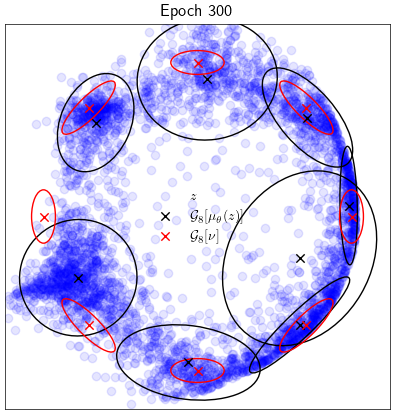

Epoch 301/1000 | Loss: 5.5659 | Diff MLE: -3.55e-06 | Time 7.02e-01s
Epoch 302/1000 | Loss: 6.3701 | Diff MLE: 2.27e-05 | Time 6.86e-01s
Epoch 303/1000 | Loss: 6.5187 | Diff MLE: -1.04e-05 | Time 7.43e-01s
Epoch 304/1000 | Loss: 5.8123 | Diff MLE: 1.49e-05 | Time 6.59e-01s
Epoch 305/1000 | Loss: 5.9702 | Diff MLE: 6.32e-06 | Time 6.58e-01s
Epoch 306/1000 | Loss: 5.7271 | Diff MLE: -9.66e-06 | Time 6.33e-01s
Epoch 307/1000 | Loss: 6.4203 | Diff MLE: -1.03e-06 | Time 6.86e-01s
Epoch 308/1000 | Loss: 6.6027 | Diff MLE: 2.91e-05 | Time 6.47e-01s
Epoch 309/1000 | Loss: 6.4388 | Diff MLE: 2.23e-06 | Time 6.58e-01s
Epoch 310/1000 | Loss: 5.9309 | Diff MLE: -9.18e-07 | Time 6.66e-01s
Epoch 311/1000 | Loss: 6.1267 | Diff MLE: 6.02e-06 | Time 6.86e-01s
Epoch 312/1000 | Loss: 6.3168 | Diff MLE: -5.92e-06 | Time 6.43e-01s
Epoch 313/1000 | Loss: 6.3117 | Diff MLE: 5.67e-06 | Time 7.49e-01s
Epoch 314/1000 | Loss: 5.7389 | Diff MLE: -9.44e-06 | Time 6.34e-01s
Epoch 315/1000 | Loss: 5.4540 | Diff MLE:

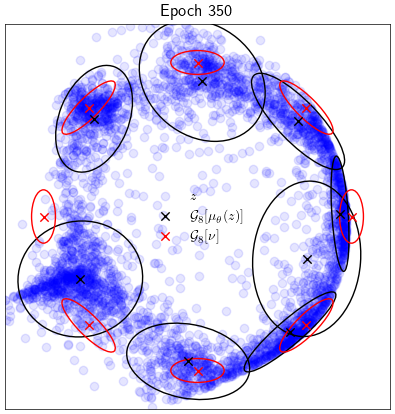

Epoch 351/1000 | Loss: 6.4981 | Diff MLE: 1.02e-05 | Time 8.26e-01s
Epoch 352/1000 | Loss: 7.2408 | Diff MLE: -7.78e-06 | Time 1.24e+00s
Epoch 353/1000 | Loss: 6.2532 | Diff MLE: 1.79e-05 | Time 1.27e+00s
Epoch 354/1000 | Loss: 5.8432 | Diff MLE: 8.20e-06 | Time 9.05e-01s
Epoch 355/1000 | Loss: 6.1622 | Diff MLE: 5.87e-06 | Time 8.25e-01s
Epoch 356/1000 | Loss: 5.8877 | Diff MLE: -4.83e-06 | Time 7.01e-01s
Epoch 357/1000 | Loss: 5.9299 | Diff MLE: 9.67e-06 | Time 6.70e-01s
Epoch 358/1000 | Loss: 6.1541 | Diff MLE: 7.23e-06 | Time 6.65e-01s
Epoch 359/1000 | Loss: 6.1406 | Diff MLE: 1.05e-05 | Time 6.62e-01s
Epoch 360/1000 | Loss: 5.8500 | Diff MLE: -2.28e-06 | Time 6.81e-01s
Epoch 361/1000 | Loss: 5.9323 | Diff MLE: -2.35e-05 | Time 6.65e-01s
Epoch 362/1000 | Loss: 5.7105 | Diff MLE: -3.62e-06 | Time 6.86e-01s
Epoch 363/1000 | Loss: 5.8724 | Diff MLE: 2.77e-06 | Time 6.66e-01s
Epoch 364/1000 | Loss: 5.8742 | Diff MLE: -2.54e-06 | Time 6.83e-01s
Epoch 365/1000 | Loss: 5.7648 | Diff MLE: 

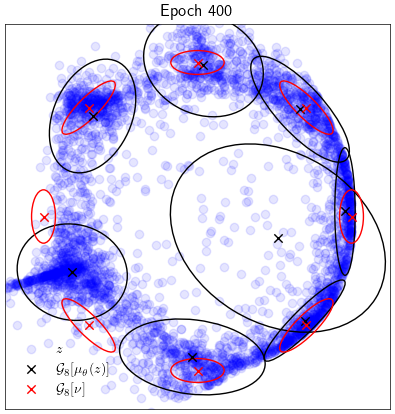

Epoch 401/1000 | Loss: 5.9562 | Diff MLE: -1.16e-05 | Time 6.62e-01s
Epoch 402/1000 | Loss: 5.6614 | Diff MLE: 2.04e-05 | Time 7.10e-01s
Epoch 403/1000 | Loss: 6.2478 | Diff MLE: 3.85e-06 | Time 6.70e-01s
Epoch 404/1000 | Loss: 5.5611 | Diff MLE: -7.85e-06 | Time 7.15e-01s
Epoch 405/1000 | Loss: 5.2370 | Diff MLE: 6.55e-06 | Time 7.09e-01s
Epoch 406/1000 | Loss: 4.9898 | Diff MLE: -1.43e-05 | Time 6.88e-01s
Epoch 407/1000 | Loss: 5.4319 | Diff MLE: -1.89e-05 | Time 6.85e-01s
Epoch 408/1000 | Loss: 5.9664 | Diff MLE: 3.03e-06 | Time 6.87e-01s
Epoch 409/1000 | Loss: 5.0715 | Diff MLE: 7.25e-06 | Time 7.08e-01s
Epoch 410/1000 | Loss: 5.3041 | Diff MLE: 1.56e-05 | Time 6.73e-01s
Epoch 411/1000 | Loss: 6.7175 | Diff MLE: 1.26e-05 | Time 6.81e-01s
Epoch 412/1000 | Loss: 6.3535 | Diff MLE: -6.11e-06 | Time 6.90e-01s
Epoch 413/1000 | Loss: 5.6362 | Diff MLE: 7.93e-06 | Time 6.76e-01s
Epoch 414/1000 | Loss: 6.4690 | Diff MLE: -1.20e-05 | Time 6.87e-01s
Epoch 415/1000 | Loss: 5.3262 | Diff MLE: 

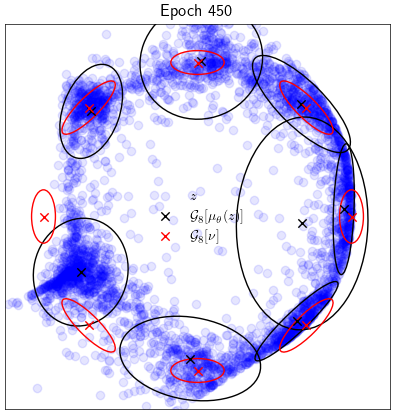

Epoch 451/1000 | Loss: 6.9317 | Diff MLE: -2.57e-06 | Time 6.79e-01s
Epoch 452/1000 | Loss: 6.4585 | Diff MLE: 1.29e-05 | Time 7.15e-01s
Epoch 453/1000 | Loss: 6.0431 | Diff MLE: -1.92e-05 | Time 7.23e-01s
Epoch 454/1000 | Loss: 5.9521 | Diff MLE: 4.64e-06 | Time 6.35e-01s
Epoch 455/1000 | Loss: 5.7159 | Diff MLE: -1.55e-05 | Time 6.24e-01s
Epoch 456/1000 | Loss: 5.7553 | Diff MLE: -7.35e-06 | Time 6.36e-01s
Epoch 457/1000 | Loss: 5.9772 | Diff MLE: 2.10e-05 | Time 6.55e-01s
Epoch 458/1000 | Loss: 5.3555 | Diff MLE: 1.04e-06 | Time 6.26e-01s
Epoch 459/1000 | Loss: 5.2586 | Diff MLE: 1.53e-05 | Time 6.60e-01s
Epoch 460/1000 | Loss: 6.7649 | Diff MLE: -1.07e-05 | Time 6.73e-01s
Epoch 461/1000 | Loss: 5.4664 | Diff MLE: 1.04e-06 | Time 6.78e-01s
Epoch 462/1000 | Loss: 6.0921 | Diff MLE: 8.91e-06 | Time 9.86e-01s
Epoch 463/1000 | Loss: 5.1635 | Diff MLE: 2.89e-06 | Time 1.23e+00s
Epoch 464/1000 | Loss: 5.3253 | Diff MLE: -1.97e-05 | Time 1.22e+00s
Epoch 465/1000 | Loss: 5.4132 | Diff MLE: 

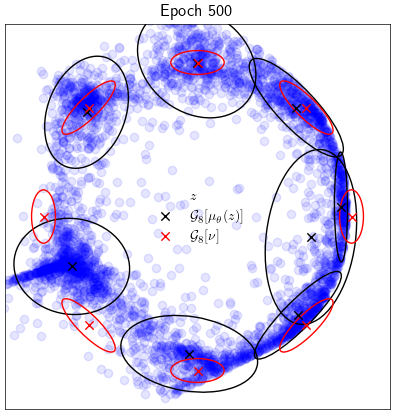

Epoch 501/1000 | Loss: 5.5059 | Diff MLE: 6.91e-06 | Time 7.23e-01s
Epoch 502/1000 | Loss: 5.5031 | Diff MLE: 2.16e-06 | Time 7.16e-01s
Epoch 503/1000 | Loss: 5.2620 | Diff MLE: -2.15e-05 | Time 7.65e-01s
Epoch 504/1000 | Loss: 6.0437 | Diff MLE: -7.83e-06 | Time 7.36e-01s
Epoch 505/1000 | Loss: 5.9216 | Diff MLE: -2.96e-06 | Time 7.19e-01s
Epoch 506/1000 | Loss: 6.6535 | Diff MLE: -2.38e-06 | Time 7.54e-01s
Epoch 507/1000 | Loss: 5.4205 | Diff MLE: -6.38e-06 | Time 7.43e-01s
Epoch 508/1000 | Loss: 6.0205 | Diff MLE: -4.63e-06 | Time 6.89e-01s
Epoch 509/1000 | Loss: 4.6179 | Diff MLE: -3.39e-06 | Time 8.11e-01s
Epoch 510/1000 | Loss: 5.2472 | Diff MLE: 5.51e-06 | Time 7.35e-01s
Epoch 511/1000 | Loss: 5.5847 | Diff MLE: -3.14e-06 | Time 7.55e-01s
Epoch 512/1000 | Loss: 5.8826 | Diff MLE: -3.37e-06 | Time 7.12e-01s
Epoch 513/1000 | Loss: 6.5019 | Diff MLE: -7.00e-06 | Time 7.11e-01s
Epoch 514/1000 | Loss: 6.3528 | Diff MLE: 5.56e-06 | Time 8.53e-01s
Epoch 515/1000 | Loss: 5.8112 | Diff M

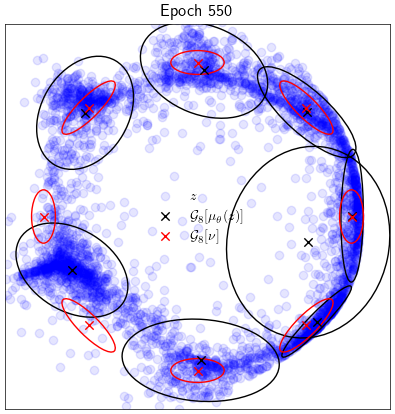

Epoch 551/1000 | Loss: 5.6316 | Diff MLE: 1.03e-05 | Time 7.70e-01s
Epoch 552/1000 | Loss: 6.3033 | Diff MLE: 2.73e-06 | Time 6.56e-01s
Epoch 553/1000 | Loss: 6.6759 | Diff MLE: -1.16e-05 | Time 7.07e-01s
Epoch 554/1000 | Loss: 5.2655 | Diff MLE: -8.52e-06 | Time 6.75e-01s
Epoch 555/1000 | Loss: 6.7940 | Diff MLE: 1.56e-05 | Time 6.72e-01s
Epoch 556/1000 | Loss: 5.5845 | Diff MLE: 1.36e-05 | Time 7.21e-01s
Epoch 557/1000 | Loss: 5.7092 | Diff MLE: 1.08e-05 | Time 7.24e-01s
Epoch 558/1000 | Loss: 5.2870 | Diff MLE: 1.37e-05 | Time 6.74e-01s
Epoch 559/1000 | Loss: 5.0532 | Diff MLE: -6.14e-06 | Time 6.97e-01s
Epoch 560/1000 | Loss: 4.9393 | Diff MLE: 1.28e-05 | Time 6.85e-01s
Epoch 561/1000 | Loss: 5.4889 | Diff MLE: 5.38e-06 | Time 6.67e-01s
Epoch 562/1000 | Loss: 5.4841 | Diff MLE: -5.12e-06 | Time 6.49e-01s
Epoch 563/1000 | Loss: 5.0751 | Diff MLE: -4.63e-06 | Time 6.84e-01s
Epoch 564/1000 | Loss: 4.9865 | Diff MLE: 4.10e-06 | Time 6.65e-01s
Epoch 565/1000 | Loss: 6.5612 | Diff MLE: -

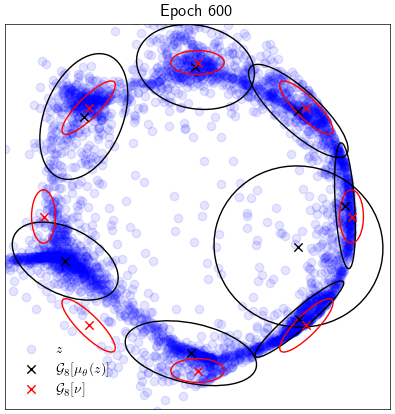

Epoch 601/1000 | Loss: 5.8839 | Diff MLE: 3.92e-06 | Time 6.47e-01s
Epoch 602/1000 | Loss: 5.5489 | Diff MLE: -1.61e-05 | Time 6.51e-01s
Epoch 603/1000 | Loss: 4.9051 | Diff MLE: 1.20e-06 | Time 7.82e-01s
Epoch 604/1000 | Loss: 5.4397 | Diff MLE: 3.67e-06 | Time 6.31e-01s
Epoch 605/1000 | Loss: 5.0887 | Diff MLE: -1.77e-05 | Time 6.30e-01s
Epoch 606/1000 | Loss: 5.7155 | Diff MLE: 2.85e-06 | Time 6.24e-01s
Epoch 607/1000 | Loss: 5.4760 | Diff MLE: -1.28e-07 | Time 6.85e-01s
Epoch 608/1000 | Loss: 5.0390 | Diff MLE: -1.45e-05 | Time 6.60e-01s
Epoch 609/1000 | Loss: 5.0274 | Diff MLE: -7.21e-06 | Time 6.34e-01s
Epoch 610/1000 | Loss: 4.7079 | Diff MLE: -7.37e-06 | Time 6.35e-01s
Epoch 611/1000 | Loss: 6.2026 | Diff MLE: 1.58e-06 | Time 6.35e-01s
Epoch 612/1000 | Loss: 6.3951 | Diff MLE: 1.49e-05 | Time 6.31e-01s
Epoch 613/1000 | Loss: 4.8117 | Diff MLE: 1.36e-05 | Time 6.33e-01s
Epoch 614/1000 | Loss: 5.4254 | Diff MLE: -9.76e-06 | Time 6.32e-01s
Epoch 615/1000 | Loss: 5.1183 | Diff MLE:

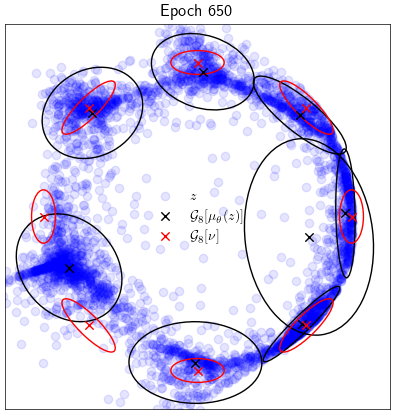

Epoch 651/1000 | Loss: 4.5213 | Diff MLE: 1.82e-07 | Time 7.55e-01s
Epoch 652/1000 | Loss: 5.0454 | Diff MLE: -2.30e-05 | Time 7.87e-01s
Epoch 653/1000 | Loss: 5.4218 | Diff MLE: -1.76e-05 | Time 7.44e-01s
Epoch 654/1000 | Loss: 5.4053 | Diff MLE: -7.44e-06 | Time 7.67e-01s
Epoch 655/1000 | Loss: 5.5434 | Diff MLE: -3.49e-06 | Time 7.35e-01s
Epoch 656/1000 | Loss: 5.5209 | Diff MLE: 3.19e-06 | Time 7.28e-01s
Epoch 657/1000 | Loss: 7.2177 | Diff MLE: 2.50e-06 | Time 7.47e-01s
Epoch 658/1000 | Loss: 7.3894 | Diff MLE: -9.99e-06 | Time 7.45e-01s
Epoch 659/1000 | Loss: 8.2054 | Diff MLE: -4.08e-06 | Time 7.45e-01s
Epoch 660/1000 | Loss: 7.8315 | Diff MLE: -3.88e-06 | Time 7.41e-01s
Epoch 661/1000 | Loss: 8.5739 | Diff MLE: -8.22e-06 | Time 7.39e-01s
Epoch 662/1000 | Loss: 8.2482 | Diff MLE: 1.14e-05 | Time 7.37e-01s
Epoch 663/1000 | Loss: 7.5654 | Diff MLE: 1.41e-05 | Time 7.47e-01s
Epoch 664/1000 | Loss: 7.9541 | Diff MLE: -3.29e-06 | Time 7.62e-01s
Epoch 665/1000 | Loss: 6.5842 | Diff ML

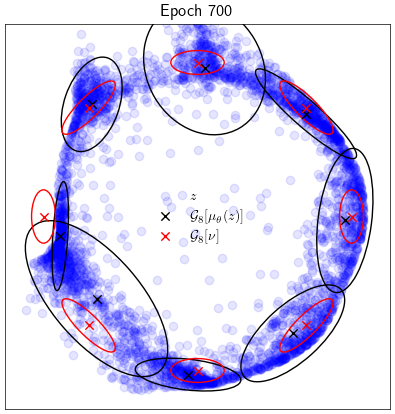

Epoch 701/1000 | Loss: 3.2772 | Diff MLE: -8.67e-06 | Time 7.47e-01s
Epoch 702/1000 | Loss: 3.3728 | Diff MLE: -4.71e-07 | Time 8.00e-01s
Epoch 703/1000 | Loss: 3.6038 | Diff MLE: -3.63e-06 | Time 7.32e-01s
Epoch 704/1000 | Loss: 4.0738 | Diff MLE: -5.70e-06 | Time 8.08e-01s
Epoch 705/1000 | Loss: 2.8171 | Diff MLE: -1.44e-05 | Time 9.04e-01s
Epoch 706/1000 | Loss: 3.8162 | Diff MLE: 1.29e-05 | Time 7.03e-01s
Epoch 707/1000 | Loss: 3.8363 | Diff MLE: -5.96e-06 | Time 7.16e-01s
Epoch 708/1000 | Loss: 3.8812 | Diff MLE: 1.01e-06 | Time 6.88e-01s
Epoch 709/1000 | Loss: 3.6184 | Diff MLE: -1.41e-05 | Time 7.16e-01s
Epoch 710/1000 | Loss: 3.4144 | Diff MLE: 3.37e-06 | Time 7.37e-01s
Epoch 711/1000 | Loss: 3.3583 | Diff MLE: 3.91e-06 | Time 7.23e-01s
Epoch 712/1000 | Loss: 3.4866 | Diff MLE: 1.01e-05 | Time 6.80e-01s
Epoch 713/1000 | Loss: 2.9811 | Diff MLE: 6.00e-07 | Time 7.12e-01s
Epoch 714/1000 | Loss: 3.1745 | Diff MLE: -1.38e-06 | Time 6.81e-01s
Epoch 715/1000 | Loss: 3.4992 | Diff MLE

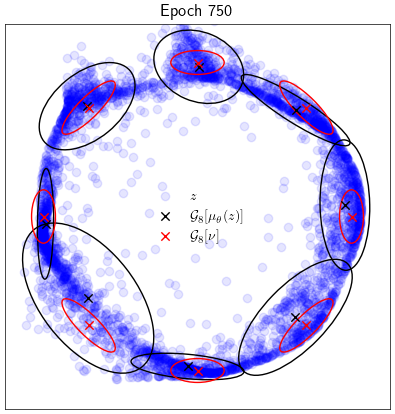

Epoch 751/1000 | Loss: 2.8352 | Diff MLE: -2.49e-06 | Time 7.89e-01s
Epoch 752/1000 | Loss: 2.7078 | Diff MLE: 6.74e-06 | Time 7.90e-01s
Epoch 753/1000 | Loss: 2.7482 | Diff MLE: -2.23e-05 | Time 8.66e-01s
Epoch 754/1000 | Loss: 3.0737 | Diff MLE: 9.20e-06 | Time 7.47e-01s
Epoch 755/1000 | Loss: 2.9947 | Diff MLE: 1.06e-05 | Time 7.49e-01s
Epoch 756/1000 | Loss: 2.2411 | Diff MLE: 7.15e-07 | Time 7.03e-01s
Epoch 757/1000 | Loss: 2.4209 | Diff MLE: 4.57e-06 | Time 7.37e-01s
Epoch 758/1000 | Loss: 2.4787 | Diff MLE: -1.32e-05 | Time 7.26e-01s
Epoch 759/1000 | Loss: 3.8821 | Diff MLE: 1.25e-05 | Time 7.23e-01s
Epoch 760/1000 | Loss: 3.6517 | Diff MLE: 8.36e-06 | Time 7.64e-01s
Epoch 761/1000 | Loss: 4.5483 | Diff MLE: -8.80e-06 | Time 7.50e-01s
Epoch 762/1000 | Loss: 3.9359 | Diff MLE: 6.97e-06 | Time 7.34e-01s
Epoch 763/1000 | Loss: 3.3254 | Diff MLE: -5.20e-06 | Time 7.95e-01s
Epoch 764/1000 | Loss: 3.5725 | Diff MLE: 2.46e-07 | Time 7.34e-01s
Epoch 765/1000 | Loss: 2.7463 | Diff MLE: 1

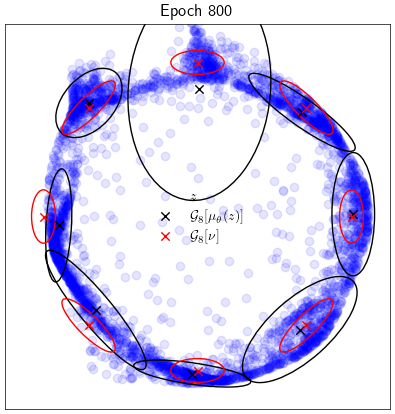

Epoch 801/1000 | Loss: 2.5067 | Diff MLE: 1.22e-05 | Time 8.78e-01s
Epoch 802/1000 | Loss: 2.3319 | Diff MLE: 7.15e-06 | Time 9.82e-01s
Epoch 803/1000 | Loss: 3.4830 | Diff MLE: 7.09e-06 | Time 7.59e-01s
Epoch 804/1000 | Loss: 3.7296 | Diff MLE: 1.24e-05 | Time 7.66e-01s
Epoch 805/1000 | Loss: 3.6035 | Diff MLE: 1.00e-05 | Time 8.30e-01s
Epoch 806/1000 | Loss: 3.5147 | Diff MLE: -2.35e-05 | Time 9.51e-01s
Epoch 807/1000 | Loss: 2.8728 | Diff MLE: 5.29e-06 | Time 8.20e-01s
Epoch 808/1000 | Loss: 2.4658 | Diff MLE: -1.16e-05 | Time 7.68e-01s
Epoch 809/1000 | Loss: 3.4759 | Diff MLE: -6.95e-06 | Time 9.90e-01s
Epoch 810/1000 | Loss: 3.1387 | Diff MLE: -7.64e-07 | Time 1.04e+00s
Epoch 811/1000 | Loss: 2.7067 | Diff MLE: 5.43e-06 | Time 1.13e+00s
Epoch 812/1000 | Loss: 2.4079 | Diff MLE: 5.72e-06 | Time 1.30e+00s
Epoch 813/1000 | Loss: 2.3596 | Diff MLE: 2.13e-06 | Time 9.63e-01s
Epoch 814/1000 | Loss: 2.7401 | Diff MLE: 1.93e-05 | Time 7.93e-01s
Epoch 815/1000 | Loss: 2.7428 | Diff MLE: -4

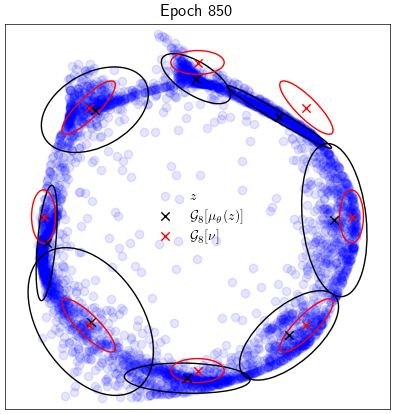

Epoch 851/1000 | Loss: 4.1104 | Diff MLE: 1.02e-05 | Time 6.76e-01s
Epoch 852/1000 | Loss: 4.6539 | Diff MLE: 1.23e-05 | Time 7.05e-01s
Epoch 853/1000 | Loss: 3.2543 | Diff MLE: -5.33e-06 | Time 6.87e-01s
Epoch 854/1000 | Loss: 3.4525 | Diff MLE: 4.15e-06 | Time 7.73e-01s
Epoch 855/1000 | Loss: 3.6063 | Diff MLE: -1.34e-05 | Time 7.77e-01s
Epoch 856/1000 | Loss: 3.5476 | Diff MLE: 4.98e-06 | Time 7.17e-01s
Epoch 857/1000 | Loss: 2.8779 | Diff MLE: 6.54e-07 | Time 7.58e-01s
Epoch 858/1000 | Loss: 2.8255 | Diff MLE: -1.11e-05 | Time 7.63e-01s
Epoch 859/1000 | Loss: 3.0310 | Diff MLE: 4.11e-06 | Time 7.52e-01s
Epoch 860/1000 | Loss: 3.3337 | Diff MLE: 1.00e-05 | Time 7.41e-01s
Epoch 861/1000 | Loss: 2.6323 | Diff MLE: 4.45e-06 | Time 8.16e-01s
Epoch 862/1000 | Loss: 3.1159 | Diff MLE: -9.72e-07 | Time 7.93e-01s
Epoch 863/1000 | Loss: 3.3993 | Diff MLE: 2.46e-06 | Time 7.71e-01s
Epoch 864/1000 | Loss: 2.7971 | Diff MLE: 1.32e-05 | Time 8.03e-01s
Epoch 865/1000 | Loss: 1.9472 | Diff MLE: 7.

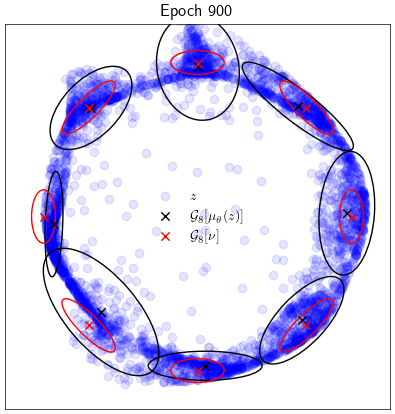

Epoch 901/1000 | Loss: 2.8710 | Diff MLE: 2.13e-05 | Time 8.77e-01s
Epoch 902/1000 | Loss: 3.0088 | Diff MLE: 5.27e-06 | Time 9.75e-01s
Epoch 903/1000 | Loss: 3.5083 | Diff MLE: 5.21e-06 | Time 7.11e-01s
Epoch 904/1000 | Loss: 3.8005 | Diff MLE: -9.15e-06 | Time 6.72e-01s
Epoch 905/1000 | Loss: 3.4368 | Diff MLE: 1.05e-05 | Time 7.24e-01s
Epoch 906/1000 | Loss: 2.2039 | Diff MLE: -1.51e-07 | Time 7.15e-01s
Epoch 907/1000 | Loss: 2.2737 | Diff MLE: 4.11e-06 | Time 6.77e-01s
Epoch 908/1000 | Loss: 2.6050 | Diff MLE: 1.31e-05 | Time 6.83e-01s
Epoch 909/1000 | Loss: 1.9082 | Diff MLE: -2.52e-05 | Time 7.99e-01s
Epoch 910/1000 | Loss: 2.5224 | Diff MLE: 8.60e-06 | Time 6.52e-01s
Epoch 911/1000 | Loss: 2.4715 | Diff MLE: -4.46e-06 | Time 6.70e-01s
Epoch 912/1000 | Loss: 1.9823 | Diff MLE: -7.19e-06 | Time 6.95e-01s
Epoch 913/1000 | Loss: 2.0329 | Diff MLE: 1.29e-05 | Time 7.33e-01s
Epoch 914/1000 | Loss: 2.1549 | Diff MLE: 3.34e-06 | Time 7.23e-01s
Epoch 915/1000 | Loss: 2.3549 | Diff MLE: -

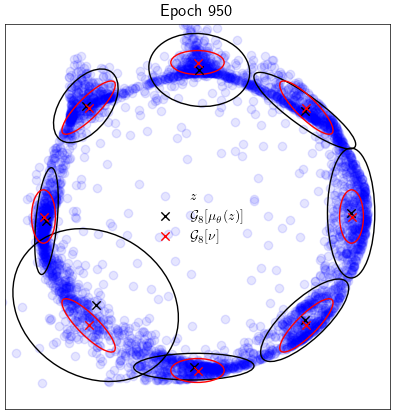

Epoch 951/1000 | Loss: 3.0567 | Diff MLE: 4.73e-07 | Time 8.71e-01s
Epoch 952/1000 | Loss: 2.5656 | Diff MLE: -9.27e-06 | Time 9.57e-01s
Epoch 953/1000 | Loss: 2.4782 | Diff MLE: 1.60e-05 | Time 7.29e-01s
Epoch 954/1000 | Loss: 1.9542 | Diff MLE: -1.65e-05 | Time 7.24e-01s
Epoch 955/1000 | Loss: 2.8088 | Diff MLE: -1.76e-05 | Time 7.21e-01s
Epoch 956/1000 | Loss: 2.6909 | Diff MLE: 7.86e-06 | Time 7.38e-01s
Epoch 957/1000 | Loss: 2.1092 | Diff MLE: 7.08e-07 | Time 7.29e-01s
Epoch 958/1000 | Loss: 2.3508 | Diff MLE: -6.25e-06 | Time 7.03e-01s
Epoch 959/1000 | Loss: 2.1230 | Diff MLE: -1.47e-05 | Time 7.26e-01s
Epoch 960/1000 | Loss: 3.0871 | Diff MLE: 1.95e-05 | Time 7.88e-01s
Epoch 961/1000 | Loss: 1.9637 | Diff MLE: -1.35e-05 | Time 8.51e-01s
Epoch 962/1000 | Loss: 2.6052 | Diff MLE: -6.14e-06 | Time 7.81e-01s
Epoch 963/1000 | Loss: 2.2642 | Diff MLE: 9.33e-06 | Time 7.35e-01s
Epoch 964/1000 | Loss: 2.3063 | Diff MLE: -1.57e-05 | Time 7.23e-01s
Epoch 965/1000 | Loss: 2.9305 | Diff MLE

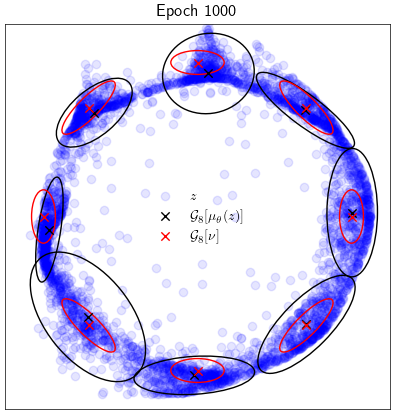

In [13]:
# optimizer = optim.Adam(f_theta.parameters(), lr=3e-4)
optimizer = optim.Adam(f_theta.parameters(), lr=3e-4)
# optimizer = torch.optim.RMSprop(f_theta.parameters(), lr=5e-4, eps=1e-5)

n_iter = 1000
n_samples_train = 4000
loss_list = []
torch.autograd.set_detect_anomaly(True)


for epoch in range(n_iter + 1):
    # time each epoch
    t0 = time.time()

    # Generate latent samples
    z = torch.randn(n_samples_train, d)

    # -----------------------------------------#
    # -----------------------------------------#

    # only if you want separate input
    # rand_mask = torch.rand(n_samples_train)
    # mask = rand_mask > 0.666
    # z[mask] = z[mask] + torch.tensor([5, 5])
    # mask = rand_mask < 0.3333
    # z[mask] = z[mask] - torch.tensor([5, 5])

    # -----------------------------------------#
    # -----------------------------------------#

    # compute mu#N(O,I)
    x_theta = f_theta(z)

    # -----------------------------------------#
    # -----------------------------------------#
    # ----------- # EM Algo # -----------------#
    # -----------------------------------------#
    # -----------------------------------------#

    # Initialization of the parameters for EM
    if epoch < 1:
        mu = x_theta[torch.randperm(n_samples_train)[:k]]
        sigma = torch.stack(
            [torch.eye(d, dtype=x_theta.dtype) for _ in range(k)]
        )  # Change to match dtype
        pi = torch.full((k,), 1 / k, dtype=x_theta.dtype, device=x_theta.device)
    else:
        mu = mu.detach().clone()
        sigma = sigma.detach().clone()
        pi = pi.detach().clone()

    # Number of epoch needed becomes inferior after the first steps
    if epoch < 10:
        max_iter = 50
        eps = 1e-3
    else:
        max_iter = 7
        eps = 1e-3

    log_likelihood_list = []
    for _ in range(max_iter):
        # E-step
        log_tau = compute_log_tau(x_theta, mu, sigma, pi, eps=eps)

        # M-step
        tau = torch.exp(log_tau)
        k = len(mu)
        n_samples = x_theta.shape[0]

        Nk = tau.sum(axis=0)
        pi = Nk / n_samples
        mu = (tau.T @ x_theta) / Nk[:, None]

        sigma = torch.stack(
            [
                (tau[:, i, None] * (x_theta - mu[i])).T
                @ (x_theta - mu[i])
                / Nk[i]
                for i in range(k)
            ]
        )

        # Log-likelihood
        log_likelihood = torch.sum(torch.logsumexp(log_tau, dim=1))
        log_likelihood_list.append(log_likelihood.item())

        if torch.isnan(log_likelihood):
            break

    # -----------------------------------------#
    # -----------------------------------------#
    # ------------ # GMM-OT # -----------------#
    # -----------------------------------------#
    # -----------------------------------------#

    loss = ot.gmm.gmm_ot_loss(mu, m_t, sigma, C_t, pi, w_t)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    time_epoch = time.time() - t0

    print(
        "Epoch %d/%d | Loss: %.4f | Diff MLE: %.2e | Time %.2es"
        % (
            epoch,
            n_iter,
            loss.item(),
            np.diff(log_likelihood_list)[-1],
            time_epoch,
        )
    )

    if epoch % 50 == 0:
        plot_training(epoch, x_theta, mu, sigma, pi, k)

## Plot the loss

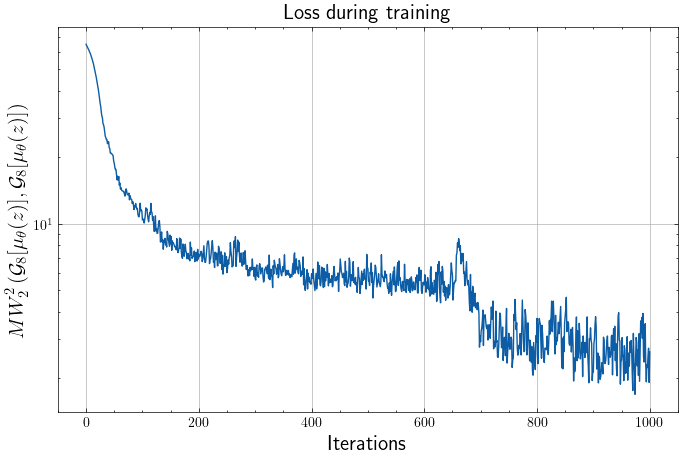

In [15]:
plt.figure(figsize=(8, 5))
plt.title("\sffamily Loss during training", fontdict={"fontsize": 15})
plt.plot(loss_list)
plt.yscale("log")
plt.xlabel("\sffamily Iterations", fontdict={"fontsize": 15})
plt.ylabel(
    rf"$$MW_2^2\left(\mathcal{{G}}_{{{k}}}[\mu_\theta(z)],\mathcal{{G}}_{{{k}}}[\mu_\theta(z)]\right)$$",
    fontdict={"fontsize": 15},
)
plt.grid()
plt.show()